# CS446/519 Homework 1

Read in the metabolic network as a directed bipartite graph (hint: use `read_csv` from `pandas`)

In [221]:
import pandas
bipartite_df = pandas.read_csv("shared/hsmetnet.txt",
                           sep="\t",
                           names=["source","target"])

Get the names of all vertices and get a list of indexes of vertices that are metabolites (hint: use `Graph.TupleList` with `directed=True`; you can use  `.values.tolist()` on the Pandas dataframe

In [222]:
import igraph
from igraph import Graph
bipartite_graph = Graph.TupleList(bipartite_df[["source","target"]].values.tolist(),
                                 directed=True)
bipartite_graph.summary()

'IGRAPH DN-- 7879 19708 -- \n+ attr: name (v)'

How many distinct metabolites are there in the graph? How many reactions? How many edges are there? (hint: use `in`, `for`, `len`, `str`, `set`, and `shape`)

In [223]:
vertex_names = bipartite_graph.vs["name"]
reaction_names = [vertex_name for vertex_name in vertex_names if "REACTION" in vertex_name]
reaction_names_set = set(reaction_names)
metabolite_names = [vertex_name for vertex_name in vertex_names if not (vertex_name in reaction_names_set)]
print("number of distinct metabolites in the graph: " + str(len(metabolite_names)))
print("number of distinct reactions in the graph: " + str(len(reaction_names)))
print("number of edges in the graph: " + str(bipartite_df.shape[0]))

number of distinct metabolites in the graph: 2340
number of distinct reactions in the graph: 5539
number of edges in the graph: 19708


What are the top six metabolites in terms of vertex degree in the graph? (hint: use `for`, `enumerate`, `sorted` (with `reverse=True`), and `lambda` or `itemgetter`)

In [224]:
metabolite_inds = [vertex_names.index(metabolite_name) for metabolite_name in metabolite_names]
metabolite_degrees = bipartite_graph.degree(metabolite_inds)
sorted_metabolites = [i[0] for i in sorted(enumerate(metabolite_degrees), 
                          key=lambda x:x[1],
                          reverse=True)]
[ metabolite_names[metabolite_id] for metabolite_id in sorted_metabolites[0:6]]

['ATP',
 'ADP',
 'phosphate',
 'peptide',
 '[protein] (L-serine/L-threonine) phosphate',
 '[protein]-(L-serine/L-threonine)']

Plot the distribution of the degrees of these vertices, on log-log scale.  (hint: use `degree_distribution` in igraph, with `vertices=metabolite_inds`; use the `.bins()` method to get the bin counts out; you can use `pylab.plot` to plot)

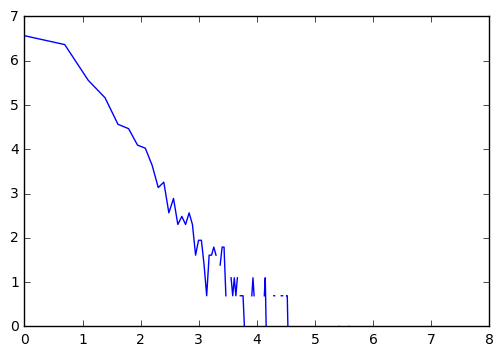

In [225]:
import matplotlib
import pylab
import numpy
metab_degree_dist = bipartite_graph.degree_distribution(vertices=metabolite_inds)

xs, ys = zip(*[(left, count) for left, _, count in metab_degree_dist.bins()])
pylab.plot(numpy.log(xs), numpy.log(ys))
pylab.show()

In [237]:
type(metab_degree_dist)

igraph.statistics.Histogram

Calculate the exponent α of the best-fit power-law (hint: use `igraph.statistics.power_law_fit`)

In [226]:
igraph.statistics.power_law_fit(metabolite_degrees).alpha

2.020246957603215

Calculate the shortest-path-length between all pairs of metabolites (vertices) in the giant weakly connected component of the graph, discarding direction information.  (hint: use `clusters` with `mode=weak` to get the giant weakly-connected component; then use `components.membership` and `enumerate` to get the giant component members; then use `igraph.shortest_distances` with `mode=igraph.ALL`, with
`source=<metabolite_vertex_indices>` and `target=<metabolite_vertex_indices>` to get the
all-pairs-shortest-paths.)

In [227]:
components = bipartite_graph.clusters(mode="weak")
metabolite_inds_giant_component =  [index for index, item in enumerate(components.membership) if item==0 and index in metabolite_inds]

In [228]:
apsp_distances = bipartite_graph.shortest_paths(source=metabolite_inds_giant_component,
                                                target=metabolite_inds_giant_component,
                                                mode=igraph.ALL)

Calculate the average of the shortest-path-length between all pairs of metabolites in the giant (weakly connected) component of the network, by throwing away any shortest-paths distance value if it is infinite. (hint: Use `numpy.array`, `numpy.isfinite` and `numpy.mean` to get the mean distance.)

In [229]:
apsp_np = numpy.array([item for sublist in apsp_distances for item in sublist])
numpy.mean(apsp_np[apsp_np > 0 & numpy.isfinite(apsp_np)])

6.7992876630967602

Calculate the maximum of the shortest-path-length between all pairs of metabolites (throwing away infinite values, as before) in the giant (weakly connected) component of the network (i.e., you are calculating the diameter of the giant component). (hint: use `numpy.max` and `numpy.isfinite`)

In [230]:
numpy.max(apsp_np[apsp_np > 0 & numpy.isfinite(apsp_np)])

18

Calculate the shortest-paths betweenness centrality for all metabolites in the directed network.  (hint: use the `betweenness` function with the `v=<vector of vertex indices>` option, with `directed=True`)

In [231]:
bc = bipartite_graph.betweenness(vertices=metabolite_inds, directed=True)

plot the scatter plot of betweenness centrality vs. vertex degree for all metabolites, on log-log scale. (hint:  use `numpy.array`, `numpy.where`, and `matplotlib.pyplot.scatter`)

In [236]:
metabolite_inds[0:100]

[0,
 2,
 3,
 4,
 6,
 7,
 8,
 9,
 11,
 12,
 13,
 14,
 16,
 17,
 19,
 20,
 21,
 22,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 39,
 40,
 41,
 42,
 44,
 45,
 47,
 48,
 49,
 51,
 52,
 54,
 55,
 56,
 57,
 59,
 60,
 62,
 63,
 65,
 66,
 67,
 68,
 70,
 71,
 72,
 73,
 75,
 76,
 77,
 78,
 80,
 83,
 85,
 86,
 88,
 89,
 90,
 92,
 93,
 95,
 96,
 97,
 98,
 100,
 101,
 103,
 104,
 105,
 107,
 108,
 109,
 110,
 112,
 113,
 114,
 115,
 117,
 119,
 121,
 122,
 124,
 126,
 127,
 128,
 129,
 130,
 132,
 133]

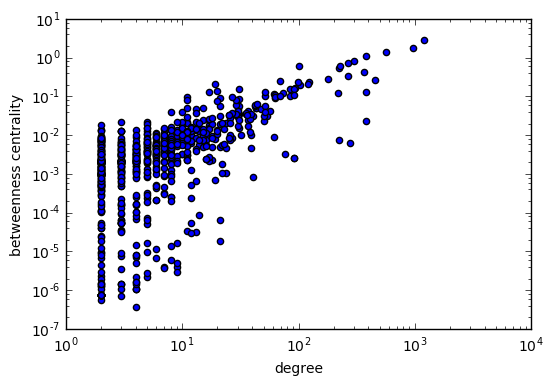

In [219]:
import matplotlib.pyplot
ax = matplotlib.pyplot.gca()
ax.set_xscale("log")
ax.set_yscale("log")
degrees = numpy.array(metabolite_degrees)
bcnp = numpy.array(bc)
Nmp = len(metabolite_inds)
inds_keep = numpy.where(bcnp > 1e-38)
ax.scatter(degrees[inds_keep], 
           bcnp[inds_keep]/((Nmp-1)*(Nmp-2)))
matplotlib.pyplot.xlabel("degree")
matplotlib.pyplot.ylabel("betweenness centrality")
matplotlib.pyplot.show()

Among metabolites with degree k=2 , what metabolite has highest betweenness centrality in the network? (hint:  use `numpy.argmax` and `numpy.where`

In [220]:
inds_deg2 = numpy.where(degrees==2)[0]
metabolite_names[inds_deg2[numpy.argmax(bcnp[inds_deg2])]]

'L-arginino-succinate'